# lifelines documentaiton example
source: https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html

In [1]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

In [2]:
# call dataset
rossi = load_rossi()
print(rossi.shape)
rossi.head()

(432, 9)


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


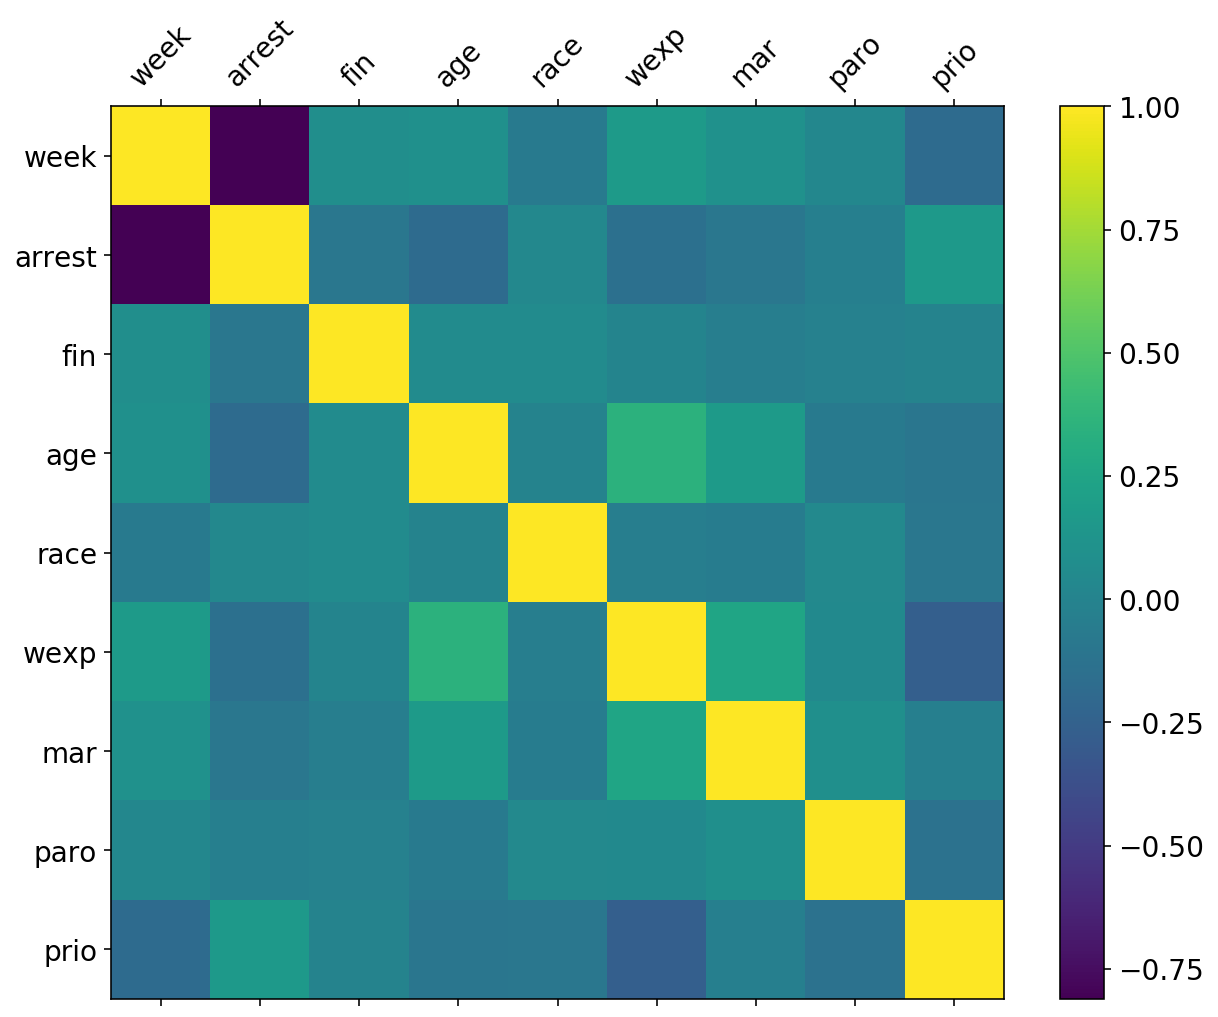

In [3]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
f = plt.figure(figsize=(10, 8))
plt.matshow(rossi.corr(), fignum=f.number)
plt.xticks(range(rossi.shape[1]), rossi.columns, fontsize=14, rotation=45)
plt.yticks(range(rossi.shape[1]), rossi.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);

In [4]:
# call CoxPHFitter
cph = CoxPHFitter()

In [5]:
# fit data
cph.fit(rossi, duration_col='week', event_col='arrest', show_progress=True)

Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 5 iterations.


<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

In [6]:
# print coefficients
print(cph.params_)

fin    -0.379422
age    -0.057438
race    0.313900
wexp   -0.149796
mar    -0.433704
paro   -0.084871
prio    0.091497
dtype: float64


## Model selection based on predictive power

Doc: https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-in-survival-regression

Three ways to view the concordance index (c-index)

In [7]:
# method one
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
partial log-likelihood = -658.75
  time fit was run = 2019-08-03 12:33:41 UTC

---
      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
fin  -0.38      0.68      0.19           -0.75           -0.00                0.47                1.00
age  -0.06      0.94      0.02           -0.10           -0.01                0.90                0.99
race  0.31      1.37      0.31           -0.29            0.92                0.75                2.50
wexp -0.15      0.86      0.21           -0.57            0.27                0.57                1.30
mar  -0.43      0.65      0.38           -1.18            0.31                0.31                1.37
paro -0.08      0.92      0.20           -0.47            0.30                0.63                1.35
prio  0.09      1.10

In [8]:
# method two
print(cph.score_)

0.6403292470997135


In [9]:
# method three
from lifelines.utils import concordance_index
print(concordance_index(rossi['week'], -cph.predict_partial_hazard(rossi), rossi['arrest']))

0.6403292470997135


In [10]:
# print baseline hazards
cph.baseline_hazard_.head()

,baseline hazard
T,
1.0,0.001958
2.0,0.001964
3.0,0.001965
4.0,0.001969
5.0,0.001975


## Cross-validation

In [11]:
from lifelines.utils import k_fold_cross_validation
import numpy as np
cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, rossi, 'week', event_col='arrest', k=3)

cv_scores = [ '%.5f' % s for s in scores ]
print('cross-validation c-index:',cv_scores)
print('c-index mean: {:2.2%}'.format(np.mean(scores)))
print('c-index std: {:2.2%}'.format(np.std(scores)))

cross-validation c-index: ['0.57328', '0.56147', '0.65518']
c-index mean: 59.66%
c-index std: 4.17%


## Prediction

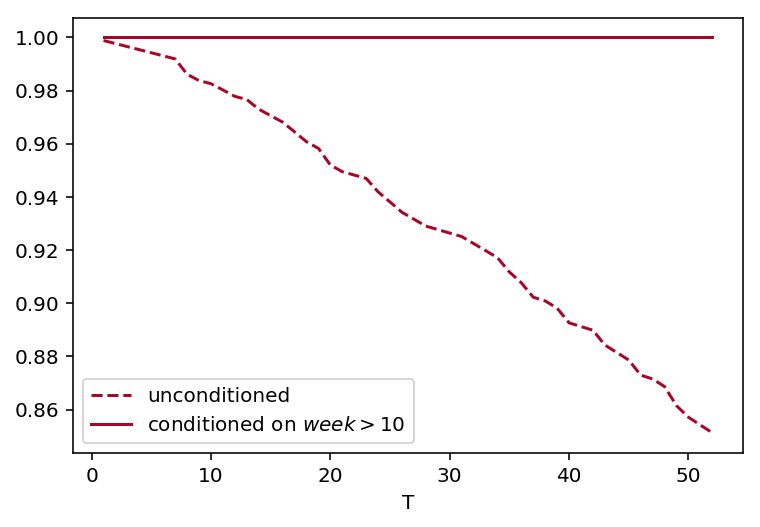

In [12]:
# to be complete...

cph_fit = cph.fit(rossi,'week','arrest')
# subseting the censored objects by setting the arrest is 0
censored_objects = rossi.loc[rossi['arrest']==0]
#
unconditioned_sf = cph.predict_survival_function(censored_objects)

conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[rossi.loc[c.name, 'week']]).clip_upper(1))

# pick a subject
subject = 13
unconditioned_sf[subject].plot(ls="--",color="#A60628",label="unconditioned")
conditioned_sf[subject].plot(color="#A60628",label="conditioned on $week > 10$")
plt.legend()
